# Eksploracja danych - zbiór `listings.csv`

Wstępny przegląd danych z pierwszej paczki

## Wnioski

* Ponad 80% ocen zawiera się między 4.5 a 5.0

In [66]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


In [2]:
def get_listings():
    return pd.read_csv('../data/raw/listings.csv')

## Wielkość zbioru danych

In [3]:
listings = get_listings()
total_len = len(listings)

review_columns = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]
listings_with_reviews = listings[listings[review_columns].notna().any(axis=1)]
len_with_reviews = len(listings_with_reviews)

print(f"Liczba przykładów w całym zbiorze {total_len}")
print(f"Liczba przykładów z oceną {len_with_reviews}")

Liczba przykładów w całym zbiorze 4195
Liczba przykładów z oceną 3223


## Atrybuty

In [4]:
listings = get_listings()
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,541377699,...,4.95,4.86,4.70,08/Z/AZ/014226-24,t,1,0,1,0,6.94
1,24793153,https://www.nocarz.pl/rooms/24793153,20241221052002,2024-12-21,previous scrape,Ganze Wohnung in Berlin Pankow,Cozy furnished and spacious 2 bedroom apartmen...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,63053103,...,4.79,4.71,4.71,First name and Last name: Jana Roskosova <br/...,f,1,1,0,0,0.67
2,9768263,https://www.nocarz.pl/rooms/9768263,20241221052002,2024-12-21,previous scrape,Loftapartment Prenzlauer Berg,"enjoy Berlin on 88 square meter in our sunny, ...",Situated in the hard of 'Prenzlauer Berg' you'...,https://a0.muscache.com/pictures/4c096212-fe21...,21256997,...,5.00,4.90,4.80,NaN,f,1,1,0,0,0.09
3,798586109549068377,https://www.nocarz.pl/rooms/798586109549068377,20241221052002,2024-12-21,city scrape,"Colorful apartment in Schillerkiez, Neukölln",Enjoy the this colorful home in “Berlin’s cool...,"Voted ""coolest neighborhood"" by Time Out Magaz...",https://a0.muscache.com/pictures/miso/Hosting-...,564509,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
4,28806732,https://www.nocarz.pl/rooms/28806732,20241221052002,2024-12-21,previous scrape,Neukölln Home,"Loft bed, fold out couch, kitchen and balcony ...",Plenty of neighbourhood bars and cafes to keep...,https://a0.muscache.com/pictures/60151487-cc67...,217262525,...,5.00,4.60,4.40,NaN,f,1,1,0,0,0.07


In [5]:
for c in listings.columns: print(c)

id
listing_url
scrape_id
last_scraped
source
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
re

## Nieprzydatne atrybuty

In [6]:
def drop_useless_columns(df):
    cols_to_drop = [
        "id",
        "listing_url",
        "scrape_id",
        "last_scraped",
        "source",
        "picture_url",
        "host_name",
        "host_url",
        "host_thumbnail_url",
        "host_picture_url",
        "calendar_last_scraped",
        "calendar_updated",  # only missing values
        "neighbourhood",
        "host_location",
        "host_neighbourhood",
        "neighbourhood_cleansed",
        "first_review",  # will not be present in new offers
        "last_review",  # will not be present in new offers
        "latitude",  # neighbourhood category should be more informative
        "longitude",  # neighbourhood category should be more informative
        "amenities",
        # this could be useful but has too many categories (1000+), maybe use one-hot encoding + embeddings?
        "reviews_per_month",  # will be missing for new offers
    ]

    return df.drop(columns=cols_to_drop)

In [7]:
# Count missing values
listings = get_listings()
cols = [
    "picture_url",
    "host_url",
    "host_thumbnail_url",
    "host_picture_url",
    "calendar_updated"
]
for col in cols:
    null_count = listings[col].isna().sum()
    print(f"{col} missing: {null_count}")


picture_url missing: 0
host_url missing: 0
host_thumbnail_url missing: 3
host_picture_url missing: 3
calendar_updated missing: 4195


## Atrybuty tekstowe

Takie, z których może da się wyciągnąć jakieś informacje, przetwarzając je w LLM, ale w tej formie nieprzydatne

In [8]:
def drop_fulltext_columns(df):
    """Text columns that are useless but could be processed with an LLM(?)"""
    text_columns = [
        "name",
        "description",
        "neighborhood_overview",
        "host_about",
        "license",
    ]

    return df.drop(columns=text_columns)

In [9]:
listings = get_listings()
text_columns = [
    "name",
    "description",
    "neighborhood_overview",
    "host_about",
    "license",
]
listings[text_columns]

,name,description,neighborhood_overview,host_about,license
0,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",NaN,NaN,08/Z/AZ/014226-24
1,Ganze Wohnung in Berlin Pankow,Cozy furnished and spacious 2 bedroom apartmen...,NaN,NaN,First name and Last name: Jana Roskosova <br/...
2,Loftapartment Prenzlauer Berg,"enjoy Berlin on 88 square meter in our sunny, ...",Situated in the hard of 'Prenzlauer Berg' you'...,NaN,NaN
3,"Colorful apartment in Schillerkiez, Neukölln",Enjoy the this colorful home in “Berlin’s cool...,"Voted ""coolest neighborhood"" by Time Out Magaz...",Passion for music and playing the piano.,NaN
4,Neukölln Home,"Loft bed, fold out couch, kitchen and balcony ...",Plenty of neighbourhood bars and cafes to keep...,NaN,NaN
...,...,...,...,...,...
4190,Cozy room in the heart of Berlin-Kreuzberg,"You can stay in a cute, cozy and quiet 13qm-ro...",The apartment is located in the heart of Kreuz...,NaN,NaN
4191,Luxuriös ausgestattetes Haus in zentraler Lage,This beautifully appointed house is quietly lo...,Highlight in the neighborhood is the Volkspark...,NaN,03/Z/RA/007662-22
4192,Cozy 1 Room Flat in Berlin Weißensee,Are you looking for a peaceful and cozy place ...,"Very peaceful and quiet, friendly.",NaN,First name and Last name: Zuzanne Abts <br/> C...
4193,Stadtflucht Homes Penthouse 5.5.1,"On the sixth floor of Lindower Strasse 18, 113...",NaN,NaN,Legal entity name and Legal form: STADTFLUCHT ...


In [10]:
for col in text_columns:
    null_count = listings[col].isna().sum()
    print(f"{col} missing: {null_count}")

name missing: 0
description missing: 185
neighborhood_overview missing: 2141
host_about missing: 2009
license missing: 1538


In [11]:
listings = drop_useless_columns(listings)

In [12]:
listings.head()

,name,description,neighborhood_overview,host_id,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",NaN,541377699,2023-10-11,NaN,within an hour,100%,100%,t,...,4.92,4.95,4.86,4.70,08/Z/AZ/014226-24,t,1,0,1,0
1,Ganze Wohnung in Berlin Pankow,Cozy furnished and spacious 2 bedroom apartmen...,NaN,63053103,2016-03-15,NaN,NaN,NaN,NaN,f,...,4.93,4.79,4.71,4.71,First name and Last name: Jana Roskosova <br/...,f,1,1,0,0
2,Loftapartment Prenzlauer Berg,"enjoy Berlin on 88 square meter in our sunny, ...",Situated in the hard of 'Prenzlauer Berg' you'...,21256997,2014-09-12,NaN,NaN,NaN,NaN,f,...,5.00,5.00,4.90,4.80,NaN,f,1,1,0,0
3,"Colorful apartment in Schillerkiez, Neukölln",Enjoy the this colorful home in “Berlin’s cool...,"Voted ""coolest neighborhood"" by Time Out Magaz...",564509,2011-05-07,Passion for music and playing the piano.,NaN,NaN,0%,f,...,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0
4,Neukölln Home,"Loft bed, fold out couch, kitchen and balcony ...",Plenty of neighbourhood bars and cafes to keep...,217262525,2018-09-25,NaN,NaN,NaN,NaN,f,...,5.00,5.00,4.60,4.40,NaN,f,1,1,0,0


In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 53 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          4195 non-null   object 
 1   description                                   4010 non-null   object 
 2   neighborhood_overview                         2054 non-null   object 
 3   host_id                                       4195 non-null   int64  
 4   host_since                                    4192 non-null   object 
 5   host_about                                    2186 non-null   object 
 6   host_response_time                            2566 non-null   object 
 7   host_response_rate                            2566 non-null   object 
 8   host_acceptance_rate                          2831 non-null   object 
 9   host_is_superhost                             4160 non-null   o

## Atrybuty nominalne binarne

Wartości `t`/`f` zamieniamy na 0/1

In [14]:
def transform_binary_columns(df):
    """To standard 0/1"""
    binary_columns = [
        "host_is_superhost",
        "host_has_profile_pic",
        "host_identity_verified",
        "has_availability",
        "instant_bookable"
    ]

    for c in binary_columns:
        unique_vals = df[c].unique()
        assert len(unique_vals) == 2 or len(unique_vals) == 3
        assert "t" in unique_vals and "f" in unique_vals

        df[c] = df[c].apply(lambda x: 1 if x == "t" else 0)

    return df

In [15]:
listings = transform_binary_columns(listings)

In [16]:
listings[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability",
          "instant_bookable"]].head(10)

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,1,1,1,1,1
1,0,1,1,1,0
2,0,1,1,1,0
3,0,1,1,1,0
4,0,1,1,1,0
5,0,1,1,1,0
6,0,1,1,1,1
7,1,1,1,1,0
8,0,0,1,1,0
9,0,1,1,1,0


In [17]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 53 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          4195 non-null   object 
 1   description                                   4010 non-null   object 
 2   neighborhood_overview                         2054 non-null   object 
 3   host_id                                       4195 non-null   int64  
 4   host_since                                    4192 non-null   object 
 5   host_about                                    2186 non-null   object 
 6   host_response_time                            2566 non-null   object 
 7   host_response_rate                            2566 non-null   object 
 8   host_acceptance_rate                          2831 non-null   object 
 9   host_is_superhost                             4195 non-null   i

## Oceny

In [18]:
def aggregate_rating_columns(df):
    """Replace all review scores columns with a single average rating column"""
    rating_columns = [
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ]
    df["avg_rating"] = df[rating_columns].mean(axis=1)
    df = df.drop(columns=rating_columns)
    return df

In [19]:
listings = get_listings()
listings = aggregate_rating_columns(listings)
listings["avg_rating"].describe()

count    3223.000000
mean        4.768786
std         0.274342
min         0.714286
25%         4.705714
50%         4.838571
75%         4.920000
max         5.000000
Name: avg_rating, dtype: float64

In [20]:
missing_ratings = listings["avg_rating"].isna().sum()
total_len = len(listings)
missing_percent = missing_ratings / total_len * 100
print(f"Missing ratings {missing_percent:.2f}%")

Missing ratings 23.17%


In [21]:
print("Q01", listings["avg_rating"].quantile(0.01))
print("Q10", listings["avg_rating"].quantile(0.10))
print("Q25", listings["avg_rating"].quantile(0.25))
print("Q75", listings["avg_rating"].quantile(0.75))
print("Q90", listings["avg_rating"].quantile(0.90))
print("Q99", listings["avg_rating"].quantile(0.99))

Q01 3.703142857142857
Q10 4.531714285714286
Q25 4.705714285714286
Q75 4.92
Q90 4.975714285714285
Q99 5.0


Mean: 4.77
Std: 0.27


[]

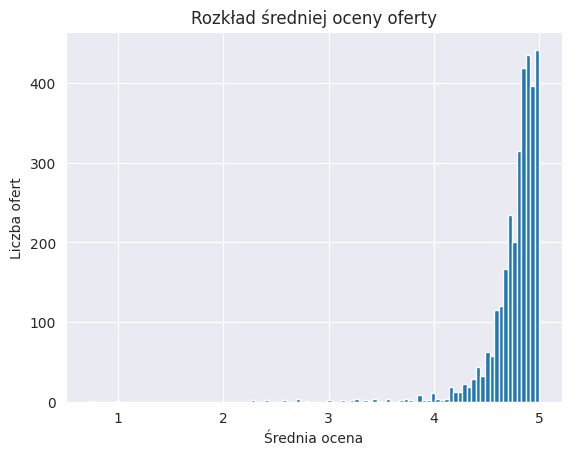

In [22]:
avg_rating = listings["avg_rating"]
print(f"Mean: {avg_rating.mean():.2f}")
print(f"Std: {avg_rating.std():.2f}")

plt.title("Rozkład średniej oceny oferty")
plt.xlabel("Średnia ocena")
plt.ylabel("Liczba ofert")
plt.hist(avg_rating, bins=100)
plt.plot()

### Atrybuty - listy


In [23]:
list_columns = [
    "host_verifications",
    "amenities",
]

In [24]:
listings = get_listings()
listings["amenities"].value_counts()

amenities
["Kitchen", "Heating", "Essentials", "Washer", "Wifi"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      23
["Heating", "Washer", "Kitchen", "Wifi"]                                                                                                                                                                                                       

In [25]:
def get_unique_values_in_list_column(df, column_name):
    all_values = set()
    for row in df[column_name]:
        if not isinstance(row, str):
            continue
        row_values = attribute_value_to_list(row)
        row_values = [a.strip() for a in row_values]
        all_values.update(row_values)

    return all_values


def attribute_value_to_list(value):
    if not isinstance(value, str):
        return []
    values = value.replace("[", "").replace("]", "").replace('"', "").replace("'", "").split(",")
    values = [a.strip() for a in values]
    return values


print(len(get_unique_values_in_list_column(listings, "host_verifications")))
print(len(get_unique_values_in_list_column(listings, "amenities")))

4
1309


In [26]:
def one_hot_encode_list_column(df, column_name):
    """One-hot encode list column"""
    all_values = get_unique_values_in_list_column(df, column_name)
    for value in all_values:
        df[f"{column_name}_{value}"] = df[column_name].apply(
            lambda x: True if value in attribute_value_to_list(x) else False)
    df.drop(columns=[column_name], inplace=True)
    return df

In [27]:
listings = one_hot_encode_list_column(listings, "host_verifications")
listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_,host_verifications_phone,host_verifications_work_email,host_verifications_email
0,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,541377699,...,t,1,0,1,0,6.94,False,True,False,True
1,24793153,https://www.nocarz.pl/rooms/24793153,20241221052002,2024-12-21,previous scrape,Ganze Wohnung in Berlin Pankow,Cozy furnished and spacious 2 bedroom apartmen...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,63053103,...,f,1,1,0,0,0.67,False,True,False,True
2,9768263,https://www.nocarz.pl/rooms/9768263,20241221052002,2024-12-21,previous scrape,Loftapartment Prenzlauer Berg,"enjoy Berlin on 88 square meter in our sunny, ...",Situated in the hard of 'Prenzlauer Berg' you'...,https://a0.muscache.com/pictures/4c096212-fe21...,21256997,...,f,1,1,0,0,0.09,False,True,True,True
3,798586109549068377,https://www.nocarz.pl/rooms/798586109549068377,20241221052002,2024-12-21,city scrape,"Colorful apartment in Schillerkiez, Neukölln",Enjoy the this colorful home in “Berlin’s cool...,"Voted ""coolest neighborhood"" by Time Out Magaz...",https://a0.muscache.com/pictures/miso/Hosting-...,564509,...,f,1,1,0,0,NaN,False,True,False,True
4,28806732,https://www.nocarz.pl/rooms/28806732,20241221052002,2024-12-21,previous scrape,Neukölln Home,"Loft bed, fold out couch, kitchen and balcony ...",Plenty of neighbourhood bars and cafes to keep...,https://a0.muscache.com/pictures/60151487-cc67...,217262525,...,f,1,1,0,0,0.07,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,21792976,https://www.nocarz.pl/rooms/21792976,20241221052002,2024-12-21,previous scrape,Cozy room in the heart of Berlin-Kreuzberg,"You can stay in a cute, cozy and quiet 13qm-ro...",The apartment is located in the heart of Kreuz...,https://a0.muscache.com/pictures/569732ef-2841...,37397114,...,f,1,0,1,0,0.04,False,True,False,True
4191,801274651309945760,https://www.nocarz.pl/rooms/801274651309945760,20241221052002,2024-12-21,city scrape,Luxuriös ausgestattetes Haus in zentraler Lage,This beautifully appointed house is quietly lo...,Highlight in the neighborhood is the Volkspark...,https://a0.muscache.com/pictures/hosting/Hosti...,107764182,...,f,1,1,0,0,0.52,False,True,False,True
4192,53988226,https://www.nocarz.pl/rooms/53988226,20241221052002,2024-12-21,city scrape,Cozy 1 Room Flat in Berlin Weißensee,Are you looking for a peaceful and cozy place ...,"Very peaceful and quiet, friendly.",https://a0.muscache.com/pictures/miso/Hosting-...,125046748,...,f,1,0,1,0,0.26,False,True,False,True
4193,826746525558682800,https://www.nocarz.pl/rooms/826746525558682800,20241221052002,2024-12-21,city scrape,Stadtflucht Homes Penthouse 5.5.1,"On the sixth floor of Lindower Strasse 18, 113...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,501025957,...,f,5,5,0,0,0.17,False,True,False,True


### Atrybuty kategoryczne

In [28]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_,host_verifications_phone,host_verifications_work_email,host_verifications_email
0,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,541377699,...,t,1,0,1,0,6.94,False,True,False,True
1,24793153,https://www.nocarz.pl/rooms/24793153,20241221052002,2024-12-21,previous scrape,Ganze Wohnung in Berlin Pankow,Cozy furnished and spacious 2 bedroom apartmen...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,63053103,...,f,1,1,0,0,0.67,False,True,False,True
2,9768263,https://www.nocarz.pl/rooms/9768263,20241221052002,2024-12-21,previous scrape,Loftapartment Prenzlauer Berg,"enjoy Berlin on 88 square meter in our sunny, ...",Situated in the hard of 'Prenzlauer Berg' you'...,https://a0.muscache.com/pictures/4c096212-fe21...,21256997,...,f,1,1,0,0,0.09,False,True,True,True
3,798586109549068377,https://www.nocarz.pl/rooms/798586109549068377,20241221052002,2024-12-21,city scrape,"Colorful apartment in Schillerkiez, Neukölln",Enjoy the this colorful home in “Berlin’s cool...,"Voted ""coolest neighborhood"" by Time Out Magaz...",https://a0.muscache.com/pictures/miso/Hosting-...,564509,...,f,1,1,0,0,NaN,False,True,False,True
4,28806732,https://www.nocarz.pl/rooms/28806732,20241221052002,2024-12-21,previous scrape,Neukölln Home,"Loft bed, fold out couch, kitchen and balcony ...",Plenty of neighbourhood bars and cafes to keep...,https://a0.muscache.com/pictures/60151487-cc67...,217262525,...,f,1,1,0,0,0.07,False,True,False,True


In [29]:
# candidates ?
categorical_columns = [
    # "host_location",
    # "host_response_time",
    # "host_neighbourhood",
    # "neighbourhood",
    # "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
    # "bathrooms_text"
]

In [30]:
print(len(listings["host_location"].unique()))
listings["host_location"].value_counts()

199


host_location
Berlin, Germany                     2997
Germany                               41
Munich, Germany                       23
Hamburg, Germany                      15
Cologne, Germany                      14
                                    ... 
Elmenhorst/Lichtenhagen, Germany       1
Schwelm, Germany                       1
Ratingen, Germany                      1
Lisbon, Portugal                       1
Slovenia                               1
Name: count, Length: 198, dtype: int64

In [31]:
def extract_host_country(df):
    """Extract host country from host_location"""

    def extract_country_from_location(location: str):
        if not "," in location:
            return location

        state = location.split(",")[-1].strip()

        if len(state) == 2:
            return "United States"

        return state

    df["host_country"] = df["host_location"].apply(
        lambda x: extract_country_from_location(x) if isinstance(x, str) else x)
    return df

In [32]:
# Prawie tylko Niemcy, chyba nie warto
listings = extract_host_country(listings)
listings["host_country"].value_counts()

host_country
Germany             3203
United States         28
Italy                 21
United Kingdom        18
Spain                 18
Switzerland           15
France                14
Austria                8
Israel                 8
Australia              7
Denmark                5
Belgium                4
Sweden                 4
Indonesia              3
Ireland                3
Canada                 3
South Korea            3
Singapore              3
Turkey                 3
Russia                 3
Mexico                 2
India                  2
Taiwan                 2
Slovenia               2
Chile                  2
Kenya                  2
South Africa           2
Thailand               1
Norway                 1
Morocco                1
Puerto Rico            1
Greece                 1
Namibia                1
Egypt                  1
Poland                 1
Colombia               1
Brazil                 1
Bulgaria               1
Hong Kong              1
French Polyn

In [33]:
print(listings["host_response_time"].value_counts())
print(listings["host_response_time"].unique())

host_response_time
within an hour        1589
within a few hours     524
within a day           339
a few days or more     114
Name: count, dtype: int64
['within an hour' nan 'within a day' 'within a few hours'
 'a few days or more']


In [34]:
def transform_host_response_time(df):
    """Transform host response time to a number"""
    #TODO adjust scale
    scale = {
        "within an hour": 1,
        "within a few hours": 2,
        "within a day": 3,
        "a few days or more": 4,
    }

    df["host_response_time"] = df["host_response_time"].apply(lambda x: scale.get(x, np.nan))
    return df

In [35]:
listings = get_listings()
listings = transform_host_response_time(listings)
print(listings["host_response_time"].value_counts())
print(listings["host_response_time"].isna().sum())

host_response_time
1.0    1589
2.0     524
3.0     339
4.0     114
Name: count, dtype: int64
1629


In [36]:
print(len(listings["host_neighbourhood"].unique()))  # Too many categories
print(len(listings["neighbourhood_cleansed"].unique()))  # Too many categories
print(len(listings["neighbourhood"].unique()))
print(len(listings["neighbourhood_group_cleansed"].unique()))

104
133
13
12


In [37]:
listings["neighbourhood"].value_counts()  # Useless

neighbourhood
Berlin, Germany                             2043
Berlin Charlottenburg, Berlin, Germany         1
Berlin-Kreuzberg, Berlin, Germany              1
Berlin, Zehlendorf, Germany                    1
Berlin, Be, Germany                            1
Berlin, Mitte, Germany                         1
Weissenhoher Strasse 14, Berlin, Germany       1
Weissensee, Berlin, Germany                    1
Berlin - Mitte, Germany                        1
Berlin, Kreuzberg, Berlin, Germany             1
Alt Treptow, Berlin, Germany                   1
Köpenick, Berlin, Germany                      1
Name: count, dtype: int64

In [38]:
listings["neighbourhood_group_cleansed"].value_counts()  # Maybe useful

neighbourhood_group_cleansed
Friedrichshain-Kreuzberg    951
Mitte                       879
Pankow                      632
Neukölln                    475
Charlottenburg-Wilm.        424
Tempelhof - Schöneberg      306
Treptow - Köpenick          179
Steglitz - Zehlendorf       114
Lichtenberg                 100
Reinickendorf                61
Spandau                      44
Marzahn - Hellersdorf        30
Name: count, dtype: int64

In [39]:
listings["property_type"].value_counts()

property_type
Entire rental unit                    2295
Private room in rental unit            941
Entire condo                           233
Room in hotel                          114
Entire serviced apartment              105
Private room in condo                   92
Entire loft                             72
Private room in home                    60
Entire home                             52
Private room in loft                    20
Private room in bed and breakfast       20
Room in boutique hotel                  18
Private room in hostel                  17
Entire guesthouse                       17
Room in serviced apartment              16
Entire townhouse                        13
Private room in serviced apartment      13
Houseboat                               11
Entire vacation home                     9
Entire guest suite                       8
Private room                             8
Private room in guesthouse               7
Room in aparthotel                      

In [40]:
def group_property_types(df):
    """Group together similar property types"""

    def transform(property_type: str):
        if "entire rental unit" in property_type.lower():
            return "entire rental unit"
        elif "room" in property_type.lower():
            return "room"
        elif "apartment" in property_type.lower():
            return "apartment"
        elif "home" in property_type.lower():
            return "home"
        elif "condo" in property_type.lower():
            return "condo"
        else:
            return "other"

    df["property_type"] = df["property_type"].apply(lambda x: transform(x) if isinstance(x, str) else x)
    return df

In [41]:
listings = get_listings()
listings = group_property_types(listings)
listings["property_type"].value_counts()

property_type
entire rental unit    2295
room                  1359
condo                  233
other                  139
apartment              105
home                    64
Name: count, dtype: int64

In [42]:
listings["room_type"].value_counts()

room_type
Entire home/apt    2842
Private room       1298
Hotel room           44
Shared room          11
Name: count, dtype: int64

In [43]:
listings["bathrooms_text"].value_counts()

bathrooms_text
1 bath               2563
1 shared bath         595
2 baths               298
1 private bath        280
1.5 baths             229
1.5 shared baths       57
2 shared baths         41
2.5 baths              30
3 baths                22
Half-bath              20
0 baths                17
0 shared baths          7
Shared half-bath        7
Private half-bath       6
3.5 baths               4
4 shared baths          3
4 baths                 3
2.5 shared baths        3
3 shared baths          3
8.5 shared baths        1
8.5 baths               1
27 baths                1
6 baths                 1
Name: count, dtype: int64

In [44]:
def extract_is_shared_from_bathrooms_text(df):
    """Extract is_shared from bathrooms_text column"""
    extract_is_shared = lambda txt: 1 if "shared" in txt.lower() else 0
    df["is_shared_bathroom"] = df["bathrooms_text"].apply(lambda x: extract_is_shared(x) if isinstance(x, str) else x)
    df = df.drop(columns=["bathrooms_text"])
    return df

In [45]:
def categorical_columns_one_hot_encoding(df):
    """One-hot encode categorical columns"""
    categorical_columns = [
        "neighbourhood_group_cleansed",
        "property_type",
        "room_type",
        "is_shared_bathroom",
    ]

    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df

## Inne atrybuty do przekształcenia

In [46]:
def transform_host_since(df):
    """Transform timestamp to number of years since"""
    current_year = datetime.now().year

    extract_years_since = lambda timestamp: current_year - int(timestamp.split("-")[0])

    df["host_since"] = df["host_since"].apply(lambda x: extract_years_since(x) if isinstance(x, str) else x)
    return df

<Axes: xlabel='host_since'>

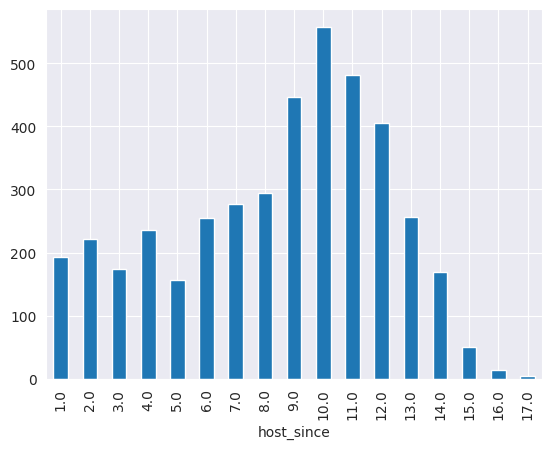

In [47]:
listings = get_listings()
listings = transform_host_since(listings)
listings["host_since"].value_counts().sort_index().plot(kind="bar")

In [48]:
listings["host_response_rate"].value_counts()

host_response_rate
100%    1930
70%      121
0%        74
90%       70
99%       40
50%       30
95%       27
98%       27
86%       26
94%       25
80%       24
67%       21
96%       13
93%       12
60%       12
97%       12
33%       11
75%       10
89%        7
91%        6
30%        5
83%        5
25%        4
85%        4
88%        4
82%        4
87%        4
71%        4
78%        3
48%        3
63%        3
10%        3
29%        3
40%        3
17%        2
72%        2
92%        2
20%        2
84%        2
13%        1
14%        1
15%        1
57%        1
46%        1
76%        1
Name: count, dtype: int64

In [49]:
listings["host_acceptance_rate"].value_counts()

host_acceptance_rate
100%    880
99%     312
0%      166
98%     118
96%      89
       ... 
41%       1
45%       1
1%        1
24%       1
19%       1
Name: count, Length: 96, dtype: int64

In [50]:
def transform_percentage_to_number(df):
    """Transform percentage to number from range [0, 1]"""
    percentage_columns = [
        "host_response_rate",
        "host_acceptance_rate",
    ]
    transform_percentage = lambda x: float(x.replace("%", "")) / 100

    for c in percentage_columns:
        df[c] = df[c].apply(lambda x: transform_percentage(x) if isinstance(x, str) else x)
    return df

In [51]:
listings = get_listings()
price = listings["price"]
print(len(price))
price.map(lambda p: str(type(p))).value_counts()

4195


price
<class 'str'>      2674
<class 'float'>    1521
Name: count, dtype: int64

In [52]:
def transform_price(df):
    """Transform price column to float"""
    transform_string_price = lambda p: float(p.replace("$", "").replace(",", ""))

    df["price"] = df["price"].apply(lambda p: transform_string_price(p) if isinstance(p, str) else p)
    return df

In [53]:
df = get_listings()
df = transform_price(df)
df["price"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4195 entries, 0 to 4194
Series name: price
Non-Null Count  Dtype  
--------------  -----  
2674 non-null   float64
dtypes: float64(1)
memory usage: 32.9 KB


### Dodatkowy atrybut - średnia ocena pozostałych ogłoszeń hosta 


In [54]:
def add_average_rating_by_host(df):
    """Add average rating by host"""
    df["avg_rating_by_host"] = df.groupby("host_id")["avg_rating"].transform("mean")
    return df


df = get_listings()
df = aggregate_rating_columns(df)
df = add_average_rating_by_host(df)
print(df["avg_rating_by_host"].info())

print(len(df[(df["avg_rating_by_host"].isna()) & (df["avg_rating"].isna())]))
print(len(df[(df["avg_rating_by_host"].notna()) & (df["avg_rating"].isna())]))
# Helps with about 20% of missing values


<class 'pandas.core.series.Series'>
RangeIndex: 4195 entries, 0 to 4194
Series name: avg_rating_by_host
Non-Null Count  Dtype  
--------------  -----  
3440 non-null   float64
dtypes: float64(1)
memory usage: 32.9 KB
None
755
217


## Normalizacja atrybutów liczbowych

In [55]:
df = get_listings()
df = drop_useless_columns(df)
df = drop_fulltext_columns(df)
df = transform_binary_columns(df)
df = aggregate_rating_columns(df)
df = transform_price(df)
df = transform_host_response_time(df)
df = extract_is_shared_from_bathrooms_text(df)
df = group_property_types(df)
df = categorical_columns_one_hot_encoding(df)
df = transform_host_since(df)
df = transform_percentage_to_number(df)
df = one_hot_encode_list_column(df, "host_verifications")
df = add_average_rating_by_host(df)
df = df.drop(columns=["host_id"])  # after adding avg_rating_by_host

# Not all should be normalized!
print(f"Numerical columns: {df.select_dtypes(include=["number"]).columns}")

print(f"Mean before normalization: {df["avg_rating_by_host"].mean()}")
print(f"Stdev before normalization: {df["avg_rating_by_host"].std()}")


def normalize_numerical_columns(df):
    """Standardize numerical columns to have mean 0 and std 1"""

    numerical_columns = [
        "maximum_nights",
        "minimum_minimum_nights",
        "maximum_minimum_nights",
        "minimum_maximum_nights",
        "maximum_maximum_nights",
        "minimum_nights_avg_ntm",
        "maximum_nights_avg_ntm",
        "availability_30",
        "availability_60",
        "availability_90",
        "availability_365",
        "number_of_reviews",
        "number_of_reviews_ltm",
        "number_of_reviews_l30d",
        "calculated_host_listings_count",
        "calculated_host_listings_count_entire_homes",
        "calculated_host_listings_count_private_rooms",
        "calculated_host_listings_count_shared_rooms",
        "price",
        "avg_rating",
        "avg_rating_by_host",
    ]
    scaler = StandardScaler()

    for c in numerical_columns:
        df[c] = scaler.fit_transform(df[[c]])

    return df


df = normalize_numerical_columns(df)

print(f"Mean after normalization: {df["avg_rating_by_host"].mean()}")
print(f"Stdev after normalization: {df["avg_rating_by_host"].std()}")


Numerical columns: Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'avg_rating',
       'avg_rating_by_host'],
      dtype=

## Final transformations

In [56]:
def transform_listings(df):
    df = drop_useless_columns(df)
    df = drop_fulltext_columns(df)
    df = transform_binary_columns(df)
    df = aggregate_rating_columns(df)
    df = transform_price(df)
    df = transform_host_response_time(df)
    df = extract_is_shared_from_bathrooms_text(df)
    df = group_property_types(df)
    df = categorical_columns_one_hot_encoding(
        df
    )  # after extracting is_shared_bathroom and grouping property types!
    df = transform_host_since(df)
    df = transform_percentage_to_number(df)
    df = one_hot_encode_list_column(df, "host_verifications")
    df = add_average_rating_by_host(df)
    df = df.drop(columns=["host_id"])  # after adding avg_rating_by_host
    df = normalize_numerical_columns(df)
    return df


In [57]:
listings = get_listings()
listings = transform_listings(listings)

In [58]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 61 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   host_since                                             4192 non-null   float64
 1   host_response_time                                     2566 non-null   float64
 2   host_response_rate                                     2566 non-null   float64
 3   host_acceptance_rate                                   2831 non-null   float64
 4   host_is_superhost                                      4195 non-null   int64  
 5   host_listings_count                                    4192 non-null   float64
 6   host_total_listings_count                              4192 non-null   float64
 7   host_has_profile_pic                                   4195 non-null   int64  
 8   host_identity_verified                          

In [59]:
listings

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,...,property_type_room,room_type_Hotel room,room_type_Private room,room_type_Shared room,is_shared_bathroom_1.0,host_verifications_,host_verifications_phone,host_verifications_work_email,host_verifications_email,avg_rating_by_host
0,2.0,1.0,1.0,1.00,1,1.0,1.0,1,1,2,...,True,False,True,False,True,False,True,False,True,0.510311
1,9.0,NaN,NaN,NaN,0,1.0,2.0,1,1,3,...,False,False,False,False,False,False,True,False,True,0.144912
2,11.0,NaN,NaN,NaN,0,1.0,4.0,1,1,4,...,False,False,False,False,False,False,True,True,True,0.587819
3,14.0,NaN,NaN,0.00,0,1.0,3.0,1,1,3,...,False,False,False,False,False,False,True,False,True,NaN
4,7.0,NaN,NaN,NaN,0,1.0,1.0,1,1,2,...,False,False,False,False,False,False,True,False,True,-0.353358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,10.0,NaN,NaN,NaN,0,1.0,1.0,1,1,1,...,True,False,True,False,True,False,True,False,True,0.427266
4191,9.0,3.0,0.7,0.63,0,1.0,1.0,1,1,5,...,False,False,False,False,False,False,True,False,True,0.377438
4192,8.0,4.0,0.0,0.00,0,1.0,1.0,1,1,1,...,True,False,True,False,True,False,True,False,True,-1.128446
4193,2.0,1.0,1.0,0.92,1,5.0,5.0,1,1,2,...,False,False,False,False,False,False,True,False,True,0.975363


## Brakujące wartości atrybutów

* Patrzymy na podzbiór gdzie brakuje oceny - to będzie nasz zbiór treningowy
* Brak price, beds, bathrooms występuje jednocześnie
* Jest mocno skorelowany z brakami w reszcie atrybutów

In [60]:
listings = listings[listings["avg_rating"].notna()]
missing_ratio = round(listings.isna().sum() / len(listings), 2)
missing_ratio[missing_ratio > 0].sort_values(ascending=False)

price                   0.36
beds                    0.36
bathrooms               0.36
host_response_time      0.35
host_response_rate      0.35
host_acceptance_rate    0.27
bedrooms                0.14
dtype: float64

In [61]:
listings_no_price = listings[listings["price"].isna()]
print(len(listings_no_price))
missing_ratio = round(listings_no_price.isna().sum() / len(listings_no_price), 2)
missing_ratio[missing_ratio > 0].sort_values(ascending=False)

1161


price                   1.00
beds                    1.00
bathrooms               1.00
host_response_time      0.79
host_response_rate      0.79
host_acceptance_rate    0.68
bedrooms                0.38
dtype: float64

In [62]:
listings_no_beds = listings[listings["beds"].isna()]
missing_ratio = round(listings_no_beds.isna().sum() / len(listings_no_beds), 2)
missing_ratio[missing_ratio > 0].sort_values(ascending=False)

beds                    1.00
bathrooms               0.99
price                   0.99
host_response_time      0.79
host_response_rate      0.79
host_acceptance_rate    0.67
bedrooms                0.38
dtype: float64

In [63]:
listings = get_listings()
len(listings)

4195

In [64]:
listings = transform_listings(get_listings())
listings.select_dtypes(include=["number"]).columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'avg_rating',
       'avg_rating_by_host'],
      dtype='object')


## Analiza korelacji atrybutów liczbowych i średniej oceny

avg_rating_by_host                              0.812079
calculated_host_listings_count                 -0.254694
calculated_host_listings_count_entire_homes    -0.242170
maximum_minimum_nights                         -0.164190
calculated_host_listings_count_private_rooms   -0.143124
availability_365                               -0.139259
availability_30                                -0.114143
availability_60                                -0.110936
availability_90                                -0.108025
minimum_minimum_nights                         -0.087439
maximum_nights                                 -0.086410
maximum_maximum_nights                         -0.083740
minimum_nights_avg_ntm                         -0.080875
maximum_nights_avg_ntm                         -0.075058
minimum_maximum_nights                         -0.061483
number_of_reviews_l30d                          0.056563
number_of_reviews_ltm                           0.055173
number_of_reviews              

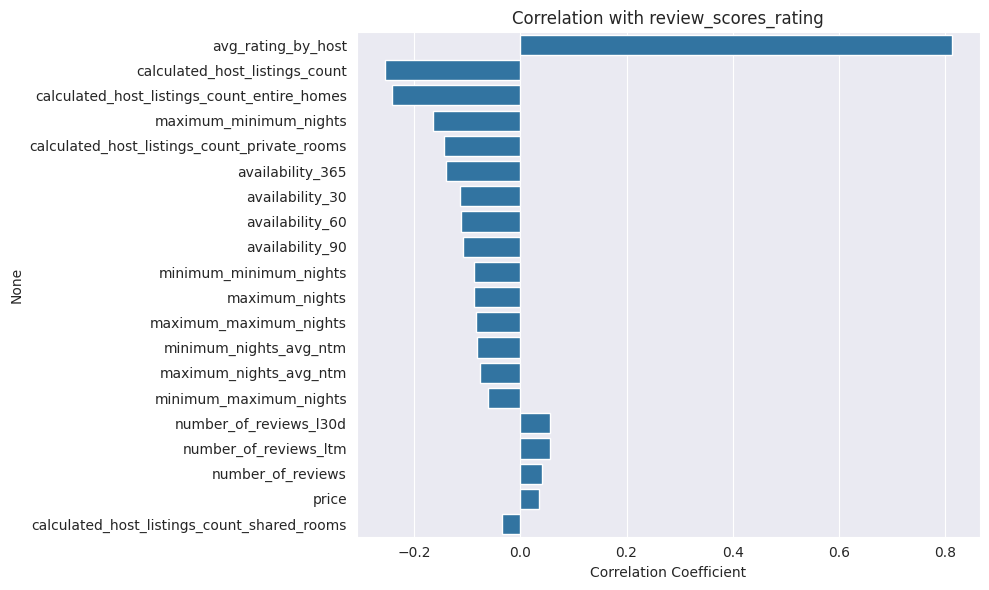

In [65]:
numerical_columns = [
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "price",
    "avg_rating_by_host",
]
target = "avg_rating"
df = transform_listings(get_listings())

non_empty = df[[target] + numerical_columns].dropna()
corr_matrix = non_empty.corr()
correlations_with_target = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)
print(correlations_with_target)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_target.values, y=correlations_with_target.index)
plt.title('Correlation with review_scores_rating')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()




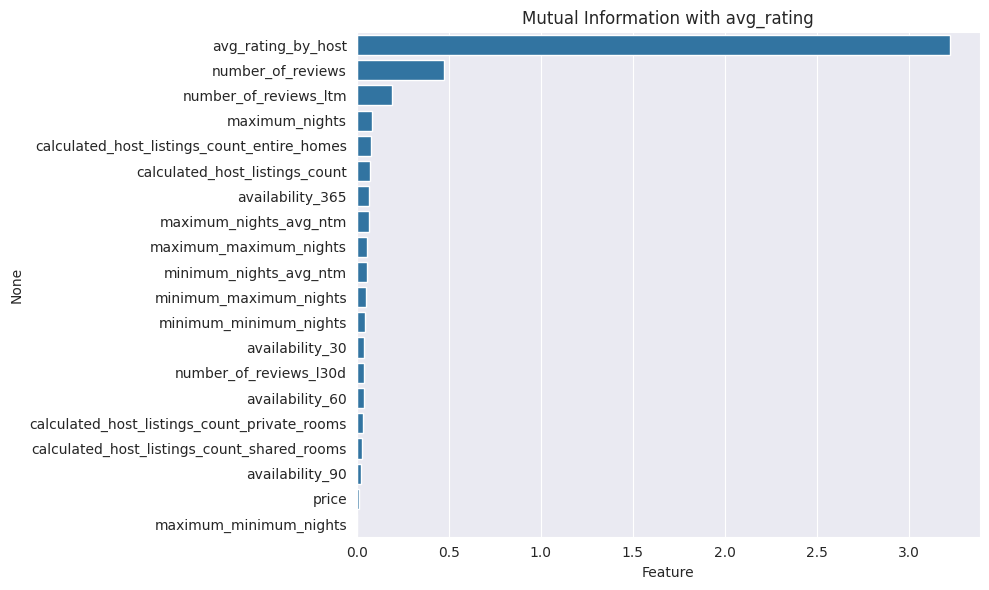

avg_rating_by_host                              3.226074
number_of_reviews                               0.475701
number_of_reviews_ltm                           0.190932
maximum_nights                                  0.082074
calculated_host_listings_count_entire_homes     0.080205
calculated_host_listings_count                  0.071988
availability_365                                0.067038
maximum_nights_avg_ntm                          0.065238
maximum_maximum_nights                          0.058819
minimum_nights_avg_ntm                          0.055982
minimum_maximum_nights                          0.048532
minimum_minimum_nights                          0.044014
availability_30                                 0.042572
number_of_reviews_l30d                          0.042106
availability_60                                 0.041981
calculated_host_listings_count_private_rooms    0.036400
calculated_host_listings_count_shared_rooms     0.030120
availability_90                

In [68]:
X = non_empty[numerical_columns]
y = non_empty[target]
mi = mutual_info_regression(X, y)
mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi.values, y=mi.index)
plt.title('Mutual Information with avg_rating')
plt.xlabel('Mutual Information')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()
print(mi)